# 딥러닝
**딥러닝(deep learning)** 은 (한 개 이상의 은닉층을 지닌) '깊은' 신경망을 의미한다. 

요즘에는 다양한 신경망 구조를 모두 아우르는 용어가 되었다.

## 19.1 텐서
1차원 배열은 벡터, 2차원 배열은 행렬으로 명명하였다. 복잡한 신경망 구조에서는 더 고차원 배열이 필요한데 대부분의 신경망 라이브러리의 명칭을 따라서 n차원 배열을 **텐서(tensor)**라고 하겠다.

텐서를 리스트로 정의해보자

In [1]:
Tensor = list

아래 코드는 텐서의 크기를 반환해 주는 도우미 함수(helper function)

In [2]:
from typing import List

def shape(tensor: Tensor) -> List[int]:
    sizes: List[int] = []
    while isinstance(tensor, list):
        sizes.append(len(tensor))
        tensor = tensor[0]
    return sizes

In [3]:
assert shape([1, 2, 3]) == [3]
assert shape([[1, 2], [3, 4], [5, 6]]) == [3, 2]

텐서마다 차원의 수가 다양하기  때문에 재귀적으로 텐서를 살펴봐야 한다. 

밑의 함수는 1차원 벡터부터 재귀적으로 고차원의 텐서까지 살펴볼 것이다.

In [4]:
def is_1d(tensor: Tensor) -> bool:
    """
    만약 tensor[0]이 리스트라면 고차원 텐서를 의미
    그러지 않으면 1차원 벡터를 의미
    """
    return not isinstance(tensor[0], list)

In [5]:
assert is_1d([1, 2, 3])
assert not is_1d([[1, 2], [3, 4]])

이런 함수를 사용해 텐서 안의 모든 값의 합을 반환해주는 tensor_sum 함수를 생성할 수 있다.

In [6]:
def tensor_sum(tensor: Tensor) -> float:
    """텐서 안의 모든 값의 합을 반환"""
    if is_1d(tensor):
        return sum(tensor)  # 벡터의 경우, 파이썬 기본 함수인 sum을 사용
    else:
        return sum(tensor_sum(tensor_i)  # 벡터가 아닌 경우, 각 행별 tensor_sum을 호출하고
                  for tensor_i in tensor)  # 결과값을 더해준다.

In [7]:
assert tensor_sum([1,2,3]) == 6
assert tensor_sum([[1,2], [3,4]]) == 10

위 else statement에 tensor_sum이 재귀적으로 사용되었다. 

매번 이렇게 재귀적으로 구현하는 것은 번거로우니 이러한 기능을 대신해 주는 도우미 함수를 만들자. 먼저 텐서 안의 모든 값에 일괄적으로 함수를 적용할 수 있게 해주는 함수를 만들어보자.

In [8]:
from typing import Callable

def tensor_apply(f: Callable[[float], float], tensor: Tensor) -> Tensor:
    """텐서 안의 모든 값에 f를 적용"""
    if is_1d(tensor):
        return [f(x) for x in tensor]
    else:
        return [tensor_apply(f, tensor_i) for tensor_i in tensor]

In [9]:
assert tensor_apply(lambda x: x + 1, [1, 2, 3]) == [2, 3, 4]
assert tensor_apply(lambda x: 2 * x, [[1, 2], [3, 4]]) == [[2, 4], [6, 8]]

위 도우미 함수를 사용하면 주어진 크기와 동일한 0 텐서를 만들 수 있다.

In [10]:
def zeros_like(tensor: Tensor) -> Tensor:
    return tensor_apply(lambda _: 0.0, tensor)

In [11]:
assert zeros_like([1,2,3]) == [0, 0, 0]
assert zeros_like([[1,2], [3, 4]]) == [[0, 0], [0, 0]]

그리고 두 텐서의 대칭되는 값에 일괄적으로 함수를 적용할 수 있게 해주는 함수를 만들어 보자.

In [12]:
def tensor_combine(f: Callable[[float, float], float],
                  t1: Tensor,
                  t2: Tensor) -> Tensor:
    """두 텐서의 대칭되는 t1과 t2에 일괄적으로 함수를 적용"""
    if is_1d(t1):
        return [f(x, y) for x, y in zip(t1, t2)]
    else:
        return [tensor_combine(f, t1_i, t2_i)
               for t1_i, t2_i in zip(t1, t2)]

In [13]:
import operator
assert tensor_combine(operator.add, [1,2,3], [4,5,6]) == [5,7,9]
assert tensor_combine(operator.mul, [1,2,3], [4,5,6]) == [4,10,18]

## 19.2 층 추상화
18장에서는 각각 sigmoid(dot(weights, inputs))를 계산해 주는 두 층으로 구성된 단순한 신경망을 만들어 보았다.

이러한 구조는 실제 뉴런이 작동하는 방식과 비슷하지만, 딥러닝에서는 다양한 신경망 구조를 사용할 것이다. 가령 각 뉴런이 이전 입력값을 기억하도록 만들거나 시그모이드 대신 다른 활성화 함수(activation function)를 사용할 것이다. 또한 두 층보다 더 깊은 신경망을 만들 것이다. (feed_forward 함수로 두 층 이상의 신경망을 만드는 것은 구현했지만 그래디언트를 계산하는 것은 아직 구현하지 않았다.)

이번 장에서는 이러한 다양한 신경망을 구현해 볼 것이다. 가장 핵심적인 **추상화** 는 신경망의 각 층을 나타내는 Layer이다. Layer에서는 입력값에 특정 함수를 적용하거나 역전파를 할 수 있어야 한다. 18장에서 구현한 신경망은 '선형'층 위에 '시그모이드' 층으로 구성된 신경망이라고 볼 수 있다.

새로운 용어라 어색할 수도 있지만 이렇게 받아들이는 것이 다양한 신경망 구조를 이해하는 데 도움이 될 것이다.

In [14]:
from typing import Iterable, Tuple

class Layer:
    """
    딥러닝 신경망은 Layer들로 구성되어 있다.
    각 Layer별로 순방향으로 입력값에 어떤 계산을 하고
    역방향으로 그래디언트를 전파해야 한다.
    """
    def forward(self, input):
        """
        타입이 명시되어 있지 않은 것을 유의하자.
        입력층과 출력값의 타입의 제한하지 않을 것이다.
        """
        raise NotImplementedError
            
    def backward(self, gradient):
        """
        역방향에서도 그래디언트의 타입을 제한하지 않을 것이다.
        메서드를 호출할 때 유의하자.
        """
        raise NotImplementedError
    
    def params(self) -> Iterable[Tensor]:
        """
        해당 층의 파라미터를 반환
        기본적으로 아무것도 반환하지 않을 것이다.
        만약 특정 층에서 반환할 파라미터가 없다면 구현할 필요가 없다.
        """
        return ()
    
    def grads(self) -> Iterable[Tensor]:
        """
        params()처럼 그래디언트를 반환
        """
        return ()

forward, backward 메서드는 곧 구현할 것이다. 그리고 경사 하강법으로 신경망의 파라미터를 학습하기 위해 각 층의 파라미터와 그래디언트를 반환해 줄 수 있어야 한다. 

시그모이드 층과 비슷한 층에서는 파라미터를 업데이트할 필요가 없기 때문에 이러한 경우를 위해 기본값 설정 또한 해주었다.

먼저 시그모이드 층을 구현해보자.

In [15]:
import math

def sigmoid(t: float) -> float:
    return 1 / (1 + math.exp(-t))

In [16]:
class Sigmoid(Layer):
    def forward(self, input: Tensor) -> Tensor:
        """
        입력된 Tensor의 모든 값에 sigmoid를 계산
        backpropagation을 위해 결괏값을 저장
        """
        self.sigmoids = tensor_apply(sigmoid, input)
        return self.sigmoids
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda sig, grad: sig * (1 - sig) * grad, self.sigmoids, gradient)

몇 가지 유의할 점이 있다. 역전파를 위해 순방향에서 계산되는 시그모이드 값을 모두 저장할 것이다. 앞으로 층의 순방향에서 계산되는 값은 대부분 저장할 것이다. 

두 번째로 sig * (1 - sig) * grad가 어디서 나왔는지 궁금할 것이다. 이 값은 18장에서 다룬 미적분과 연쇄법칙으로 계산된 output * (1 - output) * (output - target)이다.]

마지막으로 tensor_apply와 tensor_combine 함수를 사용했다. 앞으로 구현할 모든 층에서는 기본적으로 두 함수를 사용할 것이다.

## 19.3 선형 층
18장에서 구현한 신경망을 기반으로 뉴런의 dot(weights, inputs)를 나타내는 선형 층(linear layer)을 구현할 수 있다.

선형 층의 초깃값은 임의로 생성할 것이다.

사실 임의로 파라미터의 초깃값을 설정하는 것은 매우 중요하다. 파라미터의 초깃값에 따라 신경망의 학습 속도가 (혹은 학습 여부 자체가) 결정된다. 만약 초깃값이 너무 크면 활성화 함수의 그래디언트는 0에 가깝게 된다. 그래디언트가 0에 가까운 파라미터는 경사 하강법으로 학습을 할 수 없게 된다.

따라서 파라미터를 임의로 생성해 주는 세 가지 방법을 구현할 것이다. 먼저 random.random()으로 균등 분포를 구현하여, 파라미터의 초깃값을 0과 1 사이 임의의 값으로 설정할 것이다. 두 번째 방법으로 표준정규분표에서 임의의 초깃값을 생성할 것이다. 마지막으로 딥러닝에서 자주 쓰이는 Xavier 초기화에서는 평균이 0이고 편차가 2 / (입력 값의 개수 + 출력 값의 개수)인 정규분포에서 임의의 초깃값을 생성할 것이다. 세 가지 방법 모두 random_uniform과 random_normal 함수로 구현할 것이다. 

In [17]:
import random

def normal_cdf(x: float, mu: float = 0, sigma: float = 1) -> float:
    return (1 + math.erf((x - mu) / math.sqrt(2) / sigma)) / 2

def inverse_normal_cdf(p: float,
                      mu: float = 0,
                      sigma: float = 1,
                      tolerance: float = 0.00001) -> float:
    """이진 검색을 사용해 역함수를 근사"""
    # 표준정규분포가 아니라면 표준정규분포로 변환
    if mu != 0 or sigma != 1:
        return mu + sigma * inverse_normal_cdf(p, tolerance=tolerance)
    
    low_z = -10.0  # normal_cdf(-10)은 0에 근접
    hi_z = 10.0  # normal_cdf(10)은 1에 근접
    while hi_z - low_z > tolerance:
        mid_z = (low_z + hi_z) / 2  # 중간 값
        mid_p = normal_cdf(mid_z)  # 중간 값의 누적분포 값을 계산
        if mid_p < p:
            low_z = mid_z  # 중간 값이 너무 작다면 더 큰 값들을 검색
        else:
            hi_z = mid_z  # 중간 값이 너무 크다면 더 작은 값들을 검색
    
    return mid_z

In [18]:
def random_uniform(*dims: int) -> Tensor:
    if len(dims) == 1:
        return [random.random() for _ in range(dims[0])]
    else:
        return [random_uniform(*dims[1:]) for _ in range(dims[0])]

In [19]:
def random_normal(*dims: int, 
                 mean: float = 0.0,
                 variance: float = 1.0) -> Tensor:
    if len(dims) == 1:
        return [mean + variance * inverse_normal_cdf(random.random())
               for _ in range(dims[0])]
    else:
        return [random_normal(*dims[1:], mean=mean, variance=variance)
               for _ in range(dims[0])]

In [20]:
assert shape(random_uniform(2, 3, 4)) == [2, 3, 4]
assert shape(random_normal(5, 6, mean=10)) == [5, 6]

그리고 random_tensor 함수로 감싸주자.

In [21]:
def random_tensor(*dims: int, init: str = 'normal') -> Tensor:
    if init == 'normal':
        return random_normal(*dims)
    elif init == 'uniform':
        return random_uniform(*dims)
    elif init == 'xavier':
        variance = len(dims) / sum(dims)
        return random_normal(*dims, variance=variance)
    else:
        raise ValueError(f"unkown init: {init}")

이제 선형 층을 구현할 준비가 끝났다. 먼저 입력값의 차원 수(각 뉴런별 파라미터 개수), 출력값의 차원 수(뉴런의 개수), 초기화 방법을 명시해 줘야 한다. 

In [22]:
Vector = List[float]

def dot(v: Vector, w: Vector) -> float:
    """v_1 * w_1 + ... + v_n * w_n"""
    assert len(v) == len(w),  "vectors must be same length"
    
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

In [23]:
class Linear(Layer):
    def __init__(self,
                input_dim: int,
                output_dim: int,
                init: str = 'xavier') -> None:
        """
        output_dim개의 뉴런과 각 뉴런별 input_dim개의 파라미터로 (편향 제외)
        구성된 층
        """
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        # self.w[o]는 o번째 뉴런의 파라미터
        self.w = random_tensor(output_dim, input_dim, init=init)
        
        # self.b[o]는 o번째 뉴런의 편향
        self.b = random_tensor(output_dim, init=init)

선형 층의 forward 메서드는 쉽게 구현할 수 있다. 뉴런별 한 개의 값을 벡터로 저장할 것이다. 각 뉴런의 입력값과 파라미터를 곱하고 편향을 더해주면 출력값이 계산된다.

In [24]:
def forward(self, input: Tensor) -> Tensor:
    # 역방향을 위해 input을 저장
    self.input = input
    
    # 뉴런의 결괏값을 벡터로 반환
    return [dot(input, self.w[o]) + self.b[o]
           for o in range(self.output_dim)]

backward 메서드는 조금 더 복잡하지만, 미적분을 알고 있다면 금방 이해할 수 있다.

In [25]:
def backward(self, gradient: Tensor) -> Tensor:
    # 각 b[o]는 output[o]에 더해진다.
    # 즉, b의 그래디언트는 output의 그래디언트과 동일하다는 것을 의미
    self.b_grad = gradient
    
    # 각 w[o][i]를 input[i]에 곱하고 output[o]에다 더해 준다.
    # 즉, 그래디언트는 input[i] * gradient[o]
    self.w_grad = [[self.input[i] * gradient[o]
                   for i in range(self.input_dim)]
                   for o in range(self.output_dim)]
    # input[i]에 각 w[o][i]를 곱하고
    # output[o]에 더해 주기 때문에 그래디언트는 w[o][i] * gradient[o]를
    # 모두 더해 준 값
    return [sum(self.w[o][i] * gradien[o] for o in range(self.output_dim))
           for i in range(self.input_dim)]

마지막으로 params와 grads 메서드를 만들어 보자. 선형 층에는 두 개의 파라미터와 그래디언트가 있다는 것을 기억하자.

In [26]:
def params(self) -> Iterable[Tensor]:
    return [self.w, self.b]

def grads(self) -> Iterable[Tensor]:
    return [self.w_grad, self.b_grad]

## 19.4 순차적인 층으로 구성된 신경망
신경망을 순차적인 층으로 구성되어 있다고 생각해 볼 수 있다. 그렇다면 여러층을 하나의 층으로 표현할 수도 있을 것이다. 즉, 하나의 신경망 자체를 Layer의 메서드를 활용해서 하나의 층으로 표현해 보자.

In [27]:
from typing import List

class Sequential(Layer):
    """
    하나의 Layer에는 실제 여러 층이 포함되어 있다. 
    각 층의 출력값이 
    다음 층의 입력값이 된다는 것을 꼭 이해하고 넘어가자
    """
    
    def __init__(self, layers: List[Layer]) -> None:
        self.layers = layers
        
    def forward(self, input):
        """순차적으로 각 층의 입력값을 전파"""
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def backward(self, gradient):
        """역방향으로 각 층의 그래디언트를 전파"""
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
        return gradient
    
    def params(self) -> Iterable[Tensor]:
        """각 층별 파라미터를 반환"""
        return (param for layer in self.layers for param in layer.params())
    
    def grads(self) -> Iterable[Tensor]:
        """각 층별 그래디언트를 반환"""
        return (grad for layer in self.layers for grad in layer.grads())

18장에서 XOR 게이트를 위해 만들었던 신경망을 다음과 같이 만들 수 있다.

In [28]:
xor_net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=2, output_dim=1),
    Sigmoid()
])

## 19.5 손실 함수와 최적화
지금까지는 손실함수(loss function)와 그래디언트 함수를 직접 명시하였다. 이번에는 다양한 손실 함수를 살펴볼 것이며, 손실 함수와 그래디언트 계산을 loss라는 클래스로 추상화할 것이다.

In [29]:
class Loss:
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        """예측값이 얼마나 정확한가? (손실값이 크면 클수록 좋지 않은 예측값이다.)"""
        raise NotImplementedError
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        """예측값이 변하면 손실은 얼마나 변하는가?"""
        raise NotImplementedError

평균제곱오차를 손실 함수로 여러 번 사용했기에 금방 만들 수 있을 것이다. tensor_combine을 사용해야 하는 것만 기억하자.

In [31]:
class SSE(Loss):
    """평균제곱오차를 계산해 주는 손실 함수"""
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # 각 예측값의 제곱오차를 계산한 후 텐서로 표현
        squared_errors = tensor_combine(
        lambda predicted, actual: (predicted - actual) ** 2,
        predicted,
        actual)
        
        # 모든 제곱오차를 더한다.
        return tensor_sum(squared_errors)
    
    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        return tensor_combine(
        lambda predicted, actual: 2 * (predicted - actual),
        predicted, 
        actual)

경사 하강법을 구현해 보자. 지금까지는 다음의 코드처럼 에폭마다 파라미터별로 경사 하강법을 수행하였다.

In [34]:
import tqdm

def add(v: Vector, w: Vector) -> Vector:
    """각 성분끼리 더한다."""
    assert len(v) == len(w), "vector must be the same length"
    
    return [v_i + w_i for v_i, w_i in zip(v, w)]

def scalar_multiply(c: float, v: Vector) -> Vector:
    """모든 성분을 c로 곱하기"""
    return [c * v_i for v_i in v]

def gradient_step(v: Vector, gradient: Vector, step_size: float) -> Vector:
    """v에서 step_size만큼 이동하기"""
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return add(v, step)

In [37]:
theta = gradient_step(theta, grad, -learning_rate)

NameError: name 'theta' is not defined

하지만 이제는 다른 방법으로 경사 하강법을 구현해야 한다. 이번 장에서 다루는 신경망들은 수많은 파라미터로 구성되어 있으며, 이를 모두 동시에 학습시켜야 하기 때문이다. 또한 더욱 효과적으로 변형시킨, 다양한 종류의 경사 하강법을 매번 구현해서 사용하기에는 너무 번거롭다.

이러한 문제들을 해결하기 위해 Optimizer 클래스를 만들 것이다. 기존의 경사 하강법은 Optimizer 클래스의 인스턴스가 될 것이다.

In [38]:
class Optimizer:
    """
    주어진 입력값이나 층에 대한 정보(혹은 둘 다)를 사용하여
    해당 층의 파라미터를 업데이트
    """
    def step(self, layer: Layer) -> None:
        raise NotImplementedError

이제 tensor_combine을 사용하면 손쉽게 경사 하강법을 구현할 수 있다.

In [39]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate: float = 0.1) -> None:
        self.lr = learning_rate
    def step(self, layer: Layer) -> None:
        for param, grad in zip(layer.params(), layer.grads()):
            # 그래디언트만큼 param을 업데이트
            param[:] = tensor_combine(
            lambda param, grad: param - grad * self.lr,
            param,
            grad)

위 코드에서 리스트를 나눈 후 선언하는 부분이 신기할 수도 있다. 리스트를 재선언하면 리스트의 기존 값은 수정할 수 없게 된다. 만약 param = tensor_combine(...)으로 리스트를 재선언하면 param을 지역 변수(local vairable)로 선언할 수는 있지만 해당 층의 파라미터 텐서 안의 값은 수정할 수 없게 된다. 하지만 [:]을 사용하면 기존 리스트의 값을 수정할 수 있게 된다.

아래는 간단한 예시이다.

In [40]:
tensor = [[1,2], [3,4]]
for row in tensor:
    row = [0, 0]

In [41]:
assert tensor == [[1,2], [3,4]], "assignment doesn't update a list"

In [42]:
for row in tensor:
    row[:] = [0, 0]

In [44]:
assert tensor == [[0, 0], [0, 0]], "but slice assignment does"

이러한 추상화의 장점을 살려 **모맨텀(momentum)** 기반의 경사 하강법을 구현해 보자. 새롭게 계산된 그래디어튼 너무 예민하게 반응하는 것을 ㄹ방지하기 위해 지금까지 계산된 그래디언트의 평균값을 유지한다. 그리고 새 그래디언트 값이 계산될 때마다 평균값을 다시 계산하고 파라미터를 새 평균값만큼 이동시키면 된다.

In [46]:
class Momentum(Optimizer):
    def __init__(self,
                learning_rate: float,
                 momentum: float = 0.9) -> None:
        self.lr = learning_rate
        self.mo = momentum
        self.updates: List[Tensor] = []  # 이전 모든 그래디언트의 평균
    
    def step(self, layer: Layer) -> None:
        # 파라미터 업데이트가 처음이라면 0부터 시작
        if not self.updates:
            self.updates = [zeros_like(grad) for grad in layer.grads()]
            
        for update, param, grad in zip(self.updates,
                                      layer.params(),
                                      layer.grads()):
            
            # 모맨텀 적용
            update[:] = tensor_combine(
            lambda u, g: self.mo * u + (1 - self.mo) * g,
            update,
            grad)
            
            # 모맨텀을 적용한 그래디언트만큼 파라미터 업데이트
            param[:] = tensor_combine(
            lambda p, u: p - self.lr * u,
            param, 
            update)

Optimizer를 추상화했기 때문에 이제 다양한 최적화 기법을 바꿔가며 사용할 수 있다.

 ## 19.6 예시: XOR 문제 다시 풀어보기
위의 지금까지 만든 코드를 사용하면 XOR 문제를 풀어 주는 신경망을 얼마나 간편하게 학습시킬 수 있는지 살펴보자.

먼저 학습 데이터를 다시 만들어 보자.

In [47]:
# 학습 데이터
xs = [[0., 0], [0., 1], [1., 0], [1., 1]]
ys = [[0.], [1.], [1.], [0.]]    

신경망 구조를 정의해 보자. 이제 마지막 시그모이드 층을 명시해 주지 않아도 된다.

In [48]:
random.seed(0)

net = Sequential([
    Linear(input_dim=2, output_dim=2),
    Sigmoid(),
    Linear(input_dim=3, output_dim=1)
])

추상화한 Optimizer와 Loss를 사용하면 간편하게 학습을 위해 반복문을 만들 수 있다. 다양한 종류의 최적화 방법과 손실 함수를 쉽게 적용해 볼 수 있게 해준다.

In [50]:
import tqdm

optimizer = GradientDescent(learning_rate=0.1)
loss = SSE()

with tqdm.trange(3000) as t:
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
            
        t.set_description(f"xor loss {epoch_loss:.3f}")

  0%|          | 0/3000 [00:00<?, ?it/s]


NotImplementedError: 

## 19.7 다른 활성화 함수
여러 가지 이유로 이제는 시그모이드 함수를 활성화 함수로 자주 사용하지 않는다.

첫 번재 이유는 sigmoid(0)의 결괏값이 1/2이기 때문이다. 즉 뉴런에 입력되는 값의합이 0이어도 양수의 결괏값이 계산된다. 또한 매우 크거나 작은 입력값의 경우, 시그모이드의 그래디언트는 0에 수렴한다. 이런 경우, 그래디언트가 포화되었다고(saturated)하며 더는 파라미터를 업데이트할 수 없게 된다. 

시그모이드의 대안으로 tanh(쌍곡선 탄젠트, hyperbolic tangent)를 자주 사용한다. tanh는 -1부터 1사이의 시그모이드 형태의 함수이다. 만약 입력값이 0이라면 0을 반환해준다. 또한 tanh의 도함수는 1 - tanh(x) ** 2이기 때문에 간편하게 tanh 층을 구현할 수 있다.

In [51]:
import math

def tanh(x: float) -> float:
    # x가 매우 크거나 작으면 tanh는 (결국) 1이나 -1을 반환.
    # math.exp(1000)는 에러를 반환하기 때문에 x가 매우 크거나 작은 경우를 따로 확인해 줘야 한다.
    if x < -100: return -1
    elif x > 100: return 1
    
    em2x = math.exp(-2 * x)
    return (1 - em2x) / (1 + em2x)

In [52]:
class Tanh(Layer):
    def forward(self, input: Tensor) -> Tensor:
        # 역방향에서 필요한 tanh의 결괏값을 저장
        self.tanh = tensor_apply(tanh, input)
        return self.tanh
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(
        lambda tanh, grad: (1 - tanh ** 2) * grad,
        gradient)

큰 모델의 경우, Relu 또한 자주 사용한다. Relu는 음수인 입력값에 대해서는 0을 반환하지만 양수인 입력값에 대해서는 입력값을 그대로 반환한다.

In [54]:
class Relu(Layer):
    def forward(self, input: Tensor) -> Tensor:
        self.input = input
        return tensor_combine(lambda x: max(x, 0), input)
    
    def backward(self, gradient: Tensor) -> Tensor:
        return tensor_combine(lambda x, grad: grad if x > 0 else 0,
                             self.input, 
                             gradient)

이외에도 다양한 활성화 함수가 있다. 딥러닝 모델을 만들 때 이러한 대안들을 직접 사용해 보는 것 또한 추천한다.

## 19.8 예시: Fizz Buzz 다시 풀어 보기

In [55]:
def binary_encode(x: int) -> Vector:
    binary: List[float] = []

    for i in range(10):
        binary.append(x % 2)
        x = x // 2

    return binary

def fizz_buzz_encode(x: int) -> Vector:
    if x % 15 == 0:
        return [0, 0, 0, 1]
    elif x % 5 == 0:
        return [0, 0, 1, 0]
    elif x % 3 == 0:
        return [0, 1, 0, 0]
    else:
        return [1, 0, 0, 0]

def argmax(xs: list) -> int:
    """Returns the index of the largest value"""
    return max(range(len(xs)), key=lambda i: xs[i])

In [56]:
xs = [binary_encode(n) for n in range(101, 1024)]
ys = [fizz_buzz_encode(n) for n in range(101, 1024)]

모델을 만들어 보자

In [57]:
NUM_HIDDEN = 25

random.seed(0)


net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform'),
    Sigmoid()
])

학습을 진행하면서 학습데이터 안의 정확도를 기록해 보자.

In [58]:
def fizzbuzz_accuracy(low: int, hi: int, net: Layer) -> float:
    num_correct = 0
    for n in range(low, hi):
        x = binary_encode(n)
        predicted = argmax(net.forward(x))
        actual = argmax(fizz_buzz_encode(n))
        if predicted == actual:
            num_correct += 1
            
            
        return num_correct / (hi - low)

In [59]:
optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SSE()

In [60]:
with tqdm.trange(1000) as t:
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
            
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.2f} acc : {accuracy:.2f}")

  0%|          | 0/1000 [00:00<?, ?it/s]


NotImplementedError: 

In [61]:
# 테스트셋 안의 성능 검증
print('test results', fizzbuzz_accuracy(1, 101, net))

NotImplementedError: 

학습을 1,000번 반복 후, 데스트셋에서 모델의 정확도는 90%가 되었다. 만약 학습을 더욱 오랫동안 수행한다면 정확도 또한 증가할 것이다. (25개 은닉 뉴런으로는 100%의 정확도를 달성하기 어렵다. 하지만 은닉 뉴런의 수가 50개 정도 되면 충분히 가능하다.)

## 19.9 Softmax와 Cross-Entropy
앞선 다룬 모델의 마지막 층은 시그모이드 층으로 구성되었다. 즉, 이 모델의 결괏값은 0과 1사이의 값으로 구성된 벡터이다. 모든 값이 0 혹은 1로 구성된 벡터가 산출될 수도 있다. 이 모델은 분류를 위한 모델이기 때문에 , 올바르게 분휴된 경우에는 1을, 틀리게 분류된 경우에는 0을 반환하는 것이 이상적일 것이다. 하지만 대부분의 경우 환벽한 결과 예측은 불가능할 것이다. 이런 경우 적어도 클래스 간 확률분포를 계산해 보는 것도 나쁘지 않다.

예를 들어 두개의 클래스를 분류하는 경우에 모델의 결괏값이 [0, 0]이라면, 이것이 무엇을 나타내는지 이해하기 매우 힘들 것이다. 과연 결괏값이 어떠한 클래스에도 속하지 않는다는 것을 의미하는 걸까?

만약 동일한 모델의 결괏값이 [0.4, 0.6]이라면 첫 번재 클래스에 속할 확률이 0.4 두 번째 클래스에 속할 확률이 0.6이라는 것으로 이해할 수 있다.

이렇게 결괏값을 확률적으로 표현하려면 모델의 마지막 층을 시그모이드 층 대신 **소프트맥스(softmax)** 층으로 구성해야 한다. 소프트맥스 함수는 실수로 구성된 벡터를 확률로 구성된 벡터로 변환해 준다. 먼저, 벡터 안의모든 값의 exp(x)를 계산하여 양수로만 구성된 벡터로 변환한다. 그리고 각각의 값을 모든 값의 합으로 나눠준다. 그러면 모든 값의 총합이 1이 되는 확률값으로 구성된 벡터가 생성된다. 

파이썬에서 exp(1000)처럼 큰 값을 계산하게 되면 에러가 발생하기 때문에 모든 값에서 주어진 값 중 최대값을 뺀 후 exp()을 계산하자. 최종적으로 계산되는 확률값은 동일하며 파이썬에서도 문제없이 작동한다.

In [63]:
def softmax(tensor: Tensor) -> Tensor:
    """마지막 차원 안의 softmax"""
    if is_1d(tensor):
        # 에러를 피하기 위해 최대값을 빼 준다.
        largest = max(tensor)
        exps = [math.exp(x - largest) for x in tensor]
        
        sum_of_exps = sum(exps)  # 모든 값의 총합
        return [exp_i / sum_of_exps  # 확률값은 개별의 값을
                for exp_i in exps]   # 총합으로 나눈 값
    
    else:
        return [softmax(tensor_i0) for tensor_i in tensor]

모델의 결괏값이 확률값인 경우, 대부분 **크로스 엔트로피(cross entropy)** 라는 손실 함수를 사용한다. (가끔은 네거티브 로그 가능도 라고도 부른다)

앞서 14.3절 '최대 가능도 추정법'에서 (특정 가정하에) 최소자승법은 관측된 테이터가 발생할 간능도를 최대화하기 때문에 단순 회귀 분석에서 사용된다는 것을 기억해 보자.

크로스 엔트로피 또한 비슷하게 이해할 수 있다. 만약 모델의 결괏값이 확률값이라면 크로스 엔트로피 손실 함수는 관측된 데이터의 네거티트 로그 간으도를 나타낸다. 즉, 손실 함수를 최소화하는 것은 학습 데이터의 로그 가능도(그리고 가능도를)최대화하는 것을 의미한다.

소프트맥스 함수를 신경망의 일부가 아닌 손실 함수로 따로 구현하면 결괏값은 그래디언트를 쉽게 계산할 수 있게 된다. 신경망의 일부가 아닌 자제적인 손실 함수로 구현해 보자

In [64]:
class SoftmaxCrossEntropy(Loss):
    """
    주어진 딥러닝 모델에서
    관측된 데이터의 네거티브 로그 가능도를 계산.
    즉, 네거티브 로그 가능도를 최소화시키면 관측된 데이터의 가능도를 최대화하는 것과 동일
    """
    def loss(self, predicted: Tensor, actual: Tensor) -> float:
        # 소프트맥스로 확률값 생성
        probabilities = softmax(predicted)
        
        # 올바른 클래스로 분류되는 경우 log p_i를, 아닌 경우 0을 반환
        # log(0)을 피하기 위해서 p에 작은 작은 값을 더해 준다.
        likelihoods = tensor_combine(lambda p, act: math.log(p + 1e-30) * act,
                                    probabilities,
                                    actual)
        
        # 모든 네거티브 가능도를 더한다.
        return -tensor_sum(likelihoods)

    def gradient(self, predicted: Tensor, actual: Tensor) -> Tensor:
        probabilities = softmax(predicted)
        
        # 굉장히 간편하게 표현되지 않는가?
        return tensor_combine(lambda p, actual: p - actual,
                             probabilities,
                             actual)

Fizz Buzz 예시에서 만든 모델을 SoftmaxCrossEntropy에서 구현한 손실 함수로 학습하면 훨씬 빠르게(더 적은 에폭 내) 학습이 된다. 주어진 분포에서 소프트맥스로 파라미터를 찾는 게 시그모이드로 찾는 것보다 훨씬 쉽기 때문일 것이다.

만약, 선형 층 + 시그모이드 층 모델로 0번째 클래스(벡터 내 첫 번째 값이 1이고 나머지는 0인 경우)를 예측하려면 벡터 내 첫 번재 값은 매우 큰 양수이고 나머지 값은 매우 작은 음수여야 가능하다. 하지만 소프트맥스로 예측하는 경우, 첫 번째 값이 나머지 값보다 크기만 하면 된다. 후자의 경우가 훨씬 더 빈번하게 발생하기 때문에 소프트맥스로 파라미터를 학습하는 것이 훨씬 쉽다.

In [67]:
random.seed(0)

net = Sequential([
    Linear(input_dim=10, output_dim=NUM_HIDDEN, init='uniform'),
    Tanh(),
    Linear(input_dim=NUM_HIDDEN, output_dim=4, init='uniform')
    # 마지막에 시그모이드 층을 추가하지 않는다.
])

optimizer = Momentum(learning_rate=0.1, momentum=0.9)
loss = SoftmaxCrossEntropy()

with tqdm.trange(100) as f:
    for epoch in t:
        epoch_loss = 0.0
        
        for x, y in zip(xs, ys):
            predicted = net.forward(x)
            epoch_loss += loss.loss(predicted, y)
            gradient = loss.gradient(predicted, y)
            net.backward(gradient)
            
            optimizer.step(net)
        
        accuracy = fizzbuzz_accuracy(101, 1024, net)
        t.set_description(f"fb loss: {epoch_loss:.3f} acc: {accuracy:.2f}")

  0%|          | 0/100 [00:00<?, ?it/s]


NotImplementedError: 

In [68]:
# 다시 테스트셋 안의 성능 검증
print("test results", fizzbuzz_accuracy(1, 101, net))

NotImplementedError: 

## 19.10 드롭아웃
대부분의 기계학습 모델처럼 딥러닝 도한 오버티핑에 취약하다. 이미 15.8절 "Regularizaiton"에서 값이 큰 파라미터에 대해 패널티를 주는 regularization으로 오버피팅을 해결하는 것을 살펴보았다.

딥러닝에서 주로 **드롭아웃(dropout)** 으로 regularization을 수행한다. **학습 중 특정 확률로 임의의 뉴런을 '끄는 것'을 의미**한다.

드롭아웃으로 모델이 특정 뉴런에 의존하는 것을 방지할 수 있으며 오버피팅 또한 해결할 수 있다.

모델을 검증할 때는 드롭아우싱 필요 없다. 즉, 드롭아웃 층을 구현할 때는 현재 모델이 학습 중인지 아닌지 알고 있어야 한다. 만약 모델을 학습 중이라면 특정 확률값으로 선택된 임의의 입력값만 반환해 주면 된다. 그리고 모델 검증 시, 드롭아웃의 영향을 반영해 주기 위해 (모든) 출력값을 드롭아웃에 사용한 확률값 만큼 줄여줘야 한다.

In [71]:
class Dropout(Layer):
    def __init__(self, p: float) -> None:
        self.p = p
        self.train = True
        
    def forward(self, input: Tensor) -> Tensor:
        if self.train:
            # 주어진 확률값을 사용하여
            # 입력값과 동일한 크기이며 0 혹은 1로 구성된 mask를 생성
            self.mask = tensor_apply(
            lambda _: 0 if random.random() < self.p else 1,
            input)
            
            # 입력값과 mask를 곱한다.
            return tensor_combine(operator.mul, input, self.mask)
        else:
            # 검증 시, 확률값만큼 출력값을 축소
            return tensor_apply(lambda x: x * (1 - self.p), input)
        
    def backward(self, gradient: Tensor) -> Tensor:
        if self.train:
            # mask의 값이 1인 경우에만 그래디언트를 전파
            return tensor_combine(operator.mul, gradient, self.mask)
        else:
            raise RuntimeError("don't call backward when not in train mode")

앞으로 드롭아웃을 사용하여 딥러닝 모델의 오버피팅 문제를 해결할 것이다.

## 19.11 예시: MNIST
MNIST는 손으로 쓴 숫자들로 구성된 데이터셋이며 딥러닝을 처음 배우는 모든 이가 사용하는 예시이다.

처리하기 까다로운 바이너리(binary) 형태로 데이터셋이 제공되기 때문에, mnist 라이브러리를 사용할 것이다. 

In [72]:
# %pip install mnist

Note: you may need to restart the kernel to use updated packages.


In [74]:
import mnist

# 데이터를 지정한 경로에 내려받아 준다.
# (인자가 없도록 저의된 라이브러리의 함수이다.)
# (절대 이렇게 하지 않을 것이라고 했지만 람다 함수에 변수를 정의할 것이다.)
mnist.temporary_dir = lambda: '/tmp'

# 각 함수에서 데이터를 내려받고 numpy 행렬로 반환
# .tolist()를 사용해서 리스트로 변환
train_images = mnist.train_images().tolist()
train_labels = mnist.train_labels().tolist()

In [75]:
assert shape(train_images) == [60000, 28, 28]
assert shape(train_labels) == [60000]

첫 100개의 학습 데이터가 어떻게 생겼는지 한번 살펴보자

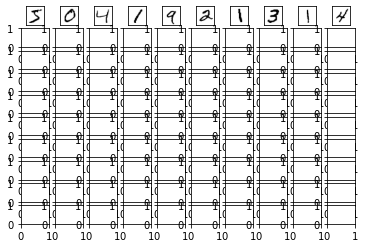

In [76]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(10, 10)
for i in range(10):
    for j in range(10):
        # 각 이미지를 흑백으로 그려보고 각 축은 숨겨 주자.
        ax[i][j].imshow(train_images[10 * i + j], cmap='Greys')
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
        
    plt.show()

위의 그림은 손으로 쓰여진 숫자인 것을 알 수 있다.

평가 데이터도 살펴보자.

In [77]:
test_images = mnist.test_images().tolist()
test_labels = mnist.test_labels().tolist()

In [78]:
assert shape(test_images) == [10000, 28, 28]
assert shape(test_labels) == [10000]

각 이미지는 28 x 28 픽셀로 구성되어 있다. 하지만 우리가 구현한 선형 층에서는 1차원 입력값만 처리할 수 있기 때문에 이미지를 1차원으로 납작하게(flatten)만들어 줄 것이다. (그리고 각 픽셀은 256으로 나눠 픽셀값을 0과 1사이로 변환해 주자) 추가적으로 입력값의 평균이 0인 경우 학습이 더 수월하기 때문에 각 픽셀값에서 평균 픽셀값을 빼주자.

In [80]:
# 평균 픽셀값 계산
avg = tensor_sum(train_images) / 60000 / 28 / 28

# 평균 픽셀값을 빼 주고, 정규화하고, 납작하게 만들어 주자.
train_images = [[(pixel - avg) / 256 for row in image for pixel in row]
               for image in train_images]

test_images = [[(pixel - avg) / 256 for row in image for pixel in row]
              for image in test_images]

In [81]:
assert shape(train_images) == [60000, 784], "images should be flattened"
assert shape(test_images) == [10000, 784], "images shoud be flattened"

In [82]:
# 평균 픽셀값을 배 주면 평균 픽셀값은 0에 가까울 것이다.
assert -0.0001 < tensor_sum(train_images) < 0.0001

10개의 출력값을 one-hot-encoding 방식으로 표현하자. 먼저 one-hot-encode 함수를 만들어 보자.

In [83]:
def one_hot_encode(i: int, num_labels: int = 10) -> List[float]:
    return [1.0 if j == i else 0.0 for j in range(num_labels)]

In [84]:
assert one_hot_encode(3) == [0,0,0,1,0,0,0,0,0,0]
assert one_hot_encode(2, num_labels=5) == [0,0,1,0,0]

데이터에 적용

In [85]:
train_labels = [one_hot_encode(label) for label in train_labels]
test_labels = [one_hot_encode(label) for label in test_labels]

In [86]:
assert shape(train_labels) == [60000, 10]
assert shape(test_labels) == [10000, 10]

추상화의 큰 장점 중 하나는 동일한 학습 및 검증 반복문으로 여러 모델을 학습할 수 있다는 점이다. 이런 반복문을 먼저 만들어 보고 모델, 데이터, 손실 함수 그리고 최적화 방식을 전달해 주자.

반복하면서 모델의 성능을 추적하며(최적화 방식이 주어졌다면) 파라미터를 업데이트할 것이다.

In [87]:
import tqdm

def loop(model: Layer,
        images: List[Tensor],
        labels: List[Tensor],
        loss: Loss,
        optimizer: Optimizer = None) -> None:
    correct = 0  # 올바르게 예측된 결괏값에 개수를 추적
    total_loss = 0.0  # 총 손실값을 추적
    
    with tqdm.trange(len(images)) as t:
        for i in t:
            predicted = model.forward(images[i])  # 예측
            if argmax(predicted) == argmax(labels[i]):  # 그리고
                correct += 1  # 결괏값 확인
            total_loss += loss.loss(predicted, labels[i])  # 손실값 계산
            # 모델이 학습 중이라면 그래디언트를 역전파하고 파라미터를 업데이트
            
            if optimizer is not None:
                gradient = loss.gradient(predicted, labels[i])
                model.backward(gradient)
                optimizer.step(model)
                
            # 그리고 출력되는 프로그래스바(progress bar)를 업데이트
            avg_loss = total_loss / (i + 1)
            acc = correct / (i + 1)
            t.set_description(f"mnist loss: {avg_loss:.3f} acc: {acc:.3f}")

비교를 위해 우리가 구현한 딥러닝 모듈로(다계층) 로지스틱 회귀 모델을 학습해보자. 로지스틱 회귀 모델은 하나의 선형 층 이후 소프트맥스를 추가해 주면 된다. 즉, 이 모델은 10개 선형 함수로 구성되어 있다고 생각하면 된다. 만약 5를 나타내는 손글씨가 입력값으로 들어온다면 5번째 선형 모델의 출력값이 가장 클 것이다.

60,000개의 이미지로 구성된 학습 데이터를 한 번만 반복 하면 모델을 충분히 학습시킬 수 있다.

In [88]:
random.seed(0)

# 로지스틱 회귀 모델은 선형 층 이후 소프트맥스를 추가한 것과 동일
model = Linear(784, 10)
loss = SoftmaxCrossEntropy()

# 이 최적화 방식을 사용해도 결과가 잘 나오는 것 같다.
optimizer = Momentum(learning_rate=0.01, momentum=0.99)

# 학습 데이터로 학습
loop(model, train_images, train_labels, loss, optimizer)

# 평가 데이터로 검증(최적화 방식을 명시하지 않으면 검증을 의미)
loop(model, test_images, test_labels, loss)

  0%|          | 0/60000 [00:00<?, ?it/s]


NotImplementedError: 

대략 89% 정도의 정확도가 계산된다. 딥러닝 모델로 정확도를 높일 수 있는지 살펴보자. 두 개의 은닉층으로 구성된 딥러닝 모델을 만들어 보자. 

첫 번째 은닉층은 30개, 두 번째 은닉층은 10개의 뉴런으로 구성해 보자. 그리고 Tanh 활성화 함수를 사용할 것이다.

In [89]:
random.seed(0)

# 켜고 끌 수 있도록 이름을 주자.
dropout1 = Dropout(0.1)
dropout2 = Dropout(0.1)

model = Sequential([
    Linear(784, 30),  # 첫 번째 은닉층의 크기: 30
    dropout1,
    Tanh(),
    Linear(30, 10),  # 두 번째 은닉층의 크기: 10
    dropout2,
    Tanh(),
    Linear(10, 10)  # 출력층의 크기: 10
])

지금까지 사용한 학습용 반복문을 그대로 사용하면 된다.

In [91]:
optimizer = Momentum(learning_rate=0.01, momentum=0.99)
loss = SoftmaxCrossEntropy()

# 드랍아웃을 적용하고 학습(노트북에서 20분 이상 걸릴 것이다!)
dropout1.train = dropout2.train = True
loop(model, train_images, train_labels, loss, optimizer)

# 드롭아웃을 제외하고 검증
dropout1.train = dropout2.train = False
loop(model, test_images, test_labels, loss)

  0%|          | 0/60000 [00:00<?, ?it/s]


NotImplementedError: 

딥러닝 모델로 평가 데이터에서 92%의 정확도를 달성할 수 있다. 간단한 로지스틱 회귀 모델보다 확실히 향상되었다.

MNIST공식 웹사이트에서 92%보다 더 좋은 성능을 보이는 모델에 대한 설명을 확인할 수 있다. 대부분의 모델은 지금까지 우리가 구현한 코드로 만들 수 있지만 굉장히 오래 걸릴 것이다. **최고의 성능을 보이는 모델은 주로 콘볼루션(convolutional)층을 사용**한다. **매우 중요한 개념**이지만 여기서는 다루지 않는다.

## 19.12 모델 저장 및 불러오기
딥러닝 모델을 학습하기 위해 굉장히 긴 시간이 필요하기 때문에 매번 모델을 학습하지 않고 학습된 모델을 저장할 수 있는 방법이 필요하다. json 모듈로 모델의 파라미터를 파일로 저장할 수 있다.

Layer.params로 모델의 모든 파라미터를 불러오고, 리스트로 변환한 뒤 json.dump로 리스트를 파일에 저장하면 된다.

In [92]:
import json

def save_weights(model: Layer, filename: str) -> None:
    weights = list(model.params())
    with open(filename, 'w') as f:
        json.dump(weights, f)

파라미터를 불러오는 것도 복잡하지 않다. 리스트 슬라이싱으로 모델의 파라미터를 설정할 수 있다.

(즉, 모델 자체의 인스턴스를 생성하고 파라미터를 불러와야 한다. 대안으로 모델의 구조를 저장하고 이를 불러오면서 모델의 인스턴스를 생성할 수도 있다. 나쁘지 않은 방법이지만 지금까지 구현한 코드를 많이 수정해야 하니 여기서는 다루지 않겠다.)

먼저 불러오는 파라미터의 크기가 모델 안의 파라미터의 크기와 동일한지 확인해야 한다.(가령 저장된 딥러닝 모델 파라미터를 얕은 신경망 모델에 불러오는 상황을 방지할 수 있다.)

In [93]:
def load_weights(model: Layer, filename: str) -> None:
    with open(filename) as f:
        weights = json.load(f)
        
    #크기 비교
    assert all(shape(param) == shape(weight)
              for param, weight in zip(model.params(), weights))
    
    # 리스트를 나누는 방식으로 파라미터를 불러온다.
    for param, weight in zip(model.params(), weights):
        param[:] = weight

JSON은 문자열로 데이터를 저장하기 때문에 매우 비효율적이다. **실제로는 pickle 라이브러리를 사용**하여 데이터를 자장할 것이다.

pickle은 바이너리 형태로 데이터를 저장하기 때문에 훨씬 효율적이다. 이 책에서는 사람이 읽을 수 있는 간단한 형태로 데이터를 저장하기 위해 JSON을 사용하였다.